## HW2: Linear Discriminant Analysis
In hw2, you need to implement [Fisher’s linear discriminant](https://towardsdatascience.com/fishers-linear-discriminant-intuitively-explained-52a1ba79e1bb) by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data

Please note that only **NUMPY** can be used to implement your model, you will get **zero point** by simply calling `sklearn.discriminant_analysis.LinearDiscriminantAnalysis` 

## Load data

In [1]:
import numpy as np

In [2]:
x_train, x_test, y_train, y_test = np.load('classification_data.npy', allow_pickle=True)

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(3750, 2)
(3750,)
(1250, 2)
(1250,)


## 1. Compute the mean vectors mi, (i=1,2) of each 2 classes

In [4]:
## Your code HERE
m1 = np.mean(x_train[y_train == 0], axis=0).reshape((x_train.shape[1], 1))

m2 = np.mean(x_train[y_train == 1], axis=0).reshape((x_train.shape[1], 1))

In [5]:
print(f"mean vector of class 1: \n{m1}\n", f"mean vector of class 2: \n{m2}")

mean vector of class 1: 
[[ 0.99253136]
 [-0.99115481]]
 mean vector of class 2: 
[[-0.9888012 ]
 [ 1.00522778]]


## 2. Compute the Within-class scatter matrix SW

In [6]:
## Your code HERE
c1_diff = (x_train[y_train == 0].T - m1)
c2_diff = (x_train[y_train == 1].T - m2)

sw = c1_diff@c1_diff.T + c2_diff@c2_diff.T


In [7]:
print(f"Within-class scatter matrix SW: \n{sw}")

Within-class scatter matrix SW: 
[[ 4337.38546493 -1795.55656547]
 [-1795.55656547  2834.75834886]]


## 3.  Compute the Between-class scatter matrix SB

In [8]:
## Your code HERE
sb = (m2 - m1)@(m2 - m1).T

In [9]:
print(f"Between-class scatter matrix SB: \n{sb}")

Between-class scatter matrix SB: 
[[ 3.92567873 -3.95549783]
 [-3.95549783  3.98554344]]


## 4. Compute the Fisher’s linear discriminant

In [10]:
# w is parallel to inverse(Sw) dot (m2-m1), and w should be an unit vector
# Use the result of dot product and divide length of the vector to get w
not_unit_w = np.linalg.inv(sw)@(m2 - m1)
w = not_unit_w / np.linalg.norm(not_unit_w)

In [11]:
print(f" Fisher's linear discriminant: \n{w}")

 Fisher's linear discriminant: 
[[-0.37003809]
 [ 0.92901658]]


## 5. Project the test data by linear discriminant and get the class prediction by `K` nearest-neighbor rule. Please report the accuracy score with `K` values from 1 to 5
you can use `accuracy_score` function from `sklearn.metric.accuracy_score`

In [12]:
def project(x, w):
    return w.T@x

def kNN(k, projected, truth, x, w):
    '''
    parameter:
        projected: previously calculated projection from train_data
        truth: ground truth class of train_data
        x: testing data
        w: projection vector, with shape(2, 1)
    '''
    y_pred = []

    for i in range(len(x)):
        proj_pos = np.array(w.T@x[i])

        '''
        1. projection can be seen as the coordinate on the line with slope w[1, 0]/w[0, 0] and intercept is 0
        2. in this for loop, calculate the distance between the new coordinate of test data and the projected coordinate of train_data (projected)
        3. find the nearest point on the line and vote for what class the test data should belong to
        4. if k is even:
            a. give each vote a weight with (1/dist[i]) / sum(1/dist), where dist is the distance between the closest k neighbors and test data, i is the voting neighbor
               in this way, we can make sure the total of weight is 1
            b. add the result of each vote, if the result >= 0.5, predict the class to be 1, else class 0
        '''
        dis_list = np.abs(proj_pos - projected)
        indices = np.argsort(dis_list, axis=1)[0, :k]
        dis_list = np.sort(dis_list, axis=1)[0, :k]

        cls_list = [truth[indices[i]] for i in range(k)]
        c2 = np.count_nonzero(cls_list)
        c1 = k - c2

        if c1 > c2:
            y_pred.append(0)
        elif c1 < c2:
            y_pred.append(1)
        else:
            weight = 1.0 / np.array(dis_list)
            norm = weight / np.sum(weight)
            weighted_pred = np.sum(cls_list * norm)
            
            if weighted_pred >= 0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)
    
    return y_pred

def accuracy_score(y, y_pred):
    from sklearn import metrics
    acc = metrics.accuracy_score(y, y_pred)
    return acc

train_proj = project(x_train.T, w)
acc_list = []
for i in range(5):
    k = i+1
    y_pred = kNN(k, train_proj, y_train, x_test, w)
    acc = accuracy_score(y_test, y_pred)
    acc_list.append(acc)
    print("k={k}, accuracy of test-set is {acc}".format(k=k, acc=acc))

print()
best_k = np.argmax(acc_list) + 1
print("Best accuracy is: k={k}, accuracy={acc}".format(k=best_k, acc=acc_list[best_k-1]))


k=1, accuracy of test-set is 0.8488
k=2, accuracy of test-set is 0.8488
k=3, accuracy of test-set is 0.8792
k=4, accuracy of test-set is 0.8824
k=5, accuracy of test-set is 0.8912

Best accuracy is: k=5, accuracy=0.8912


## 6. Plot the 1) best projection line on the training data and show the slope and intercept on the title (you can choose any value of intercept for better visualization) 2) colorize the data with each class 3) project all data points on your projection line. Your result should look like [this image](https://i.imgur.com/tubMQpw.jpg)

(-5.62597401986378, 5.180672031299692, -4.180574620201468, 6.626071430962004)

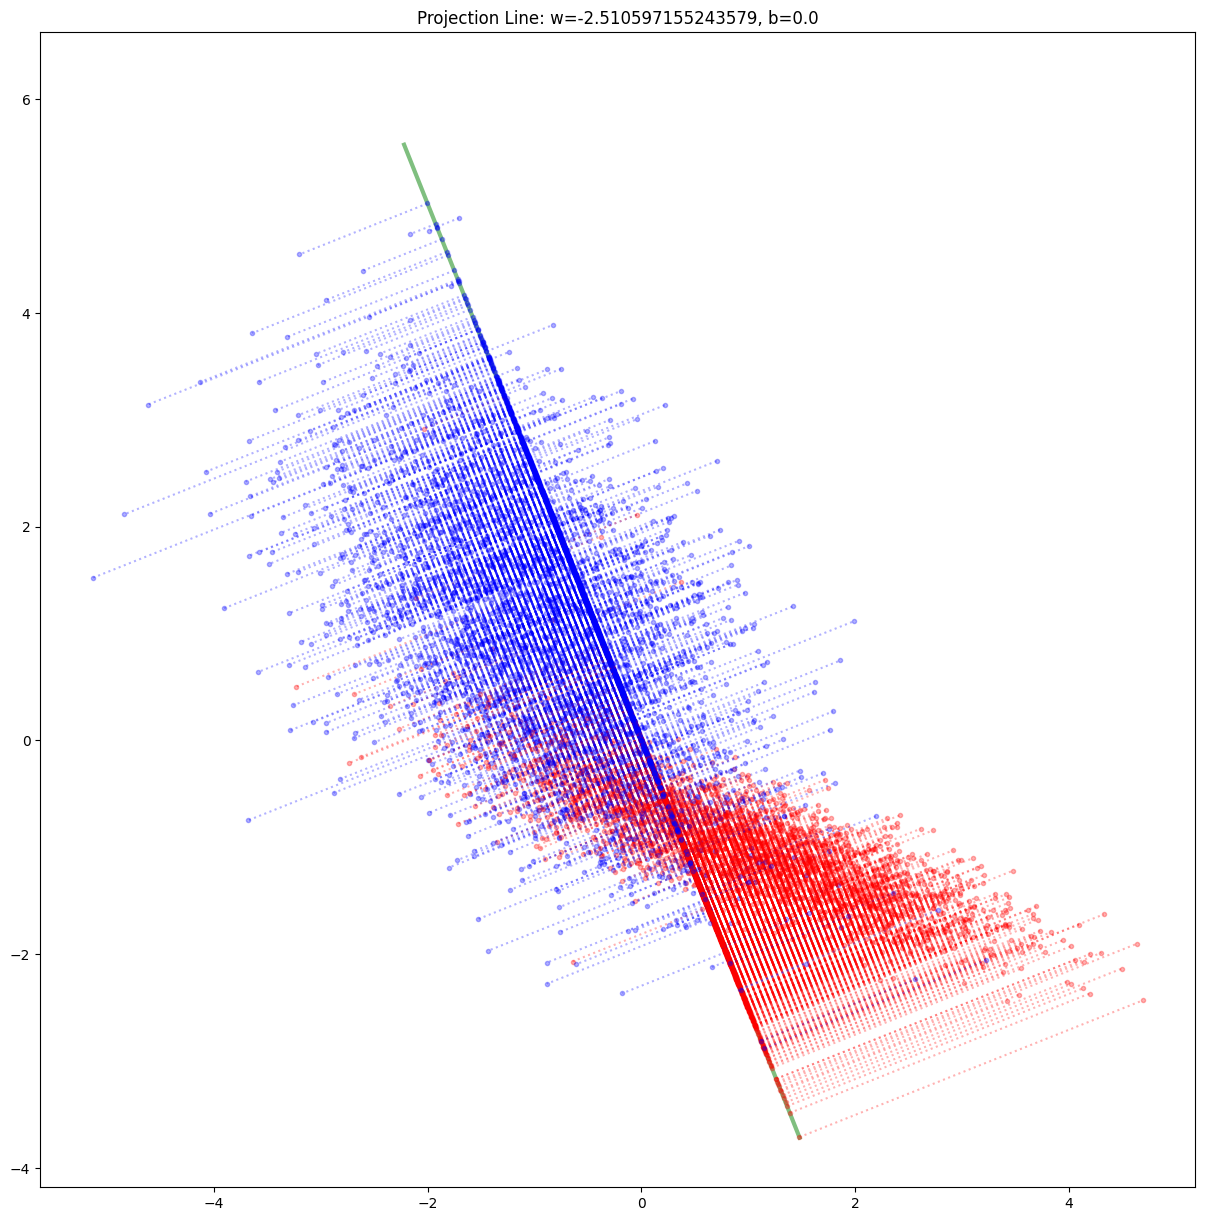

In [13]:
import matplotlib.pyplot as plt

c1_list = [idx for idx in range(len(y_train)) if y_train[idx] == 0]
c2_list = [idx for idx in range(len(y_train)) if y_train[idx] == 1]

plt.figure(figsize=(15, 15))
plt.plot([-w[0, 0] * 4, w[0, 0] * 6], [-w[1, 0] * 4, w[1, 0] * 6], lw=3, color="green", alpha=0.5) # this is the solution line
plt.title("Projection Line: w={slope}, b={intercept}".format(slope=w[1, 0]/w[0, 0], intercept=0.0))

for idx in c1_list:
    r = train_proj[0, idx] * w  # projection coordinate(2D)
    plt.plot([r[0, 0], x_train[idx][0]], [r[1, 0], x_train[idx][1]], 'r.:', alpha=0.3)
for idx in c2_list:
    r = train_proj[0, idx] * w  # projection coordinate(2D)
    plt.plot([r[0, 0], x_train[idx][0]], [r[1, 0], x_train[idx][1]], 'b.:', alpha=0.3)

c1_list = [idx for idx in range(len(y_test)) if y_test[idx] == 0]
c2_list = [idx for idx in range(len(y_test)) if y_test[idx] == 1]
test_proj = project(x_test.T, w)

for idx in c1_list:
    r = test_proj[0, idx] * w  # projection coordinate(2D)
    plt.plot([r[0, 0], x_test[idx][0]], [r[1, 0], x_test[idx][1]], 'r.:', alpha=0.3)
for idx in c2_list:
    r = test_proj[0, idx] * w  # projection coordinate(2D)
    plt.plot([r[0, 0], x_test[idx][0]], [r[1, 0], x_test[idx][1]], 'b.:', alpha=0.3)


plt.gca().axis('square')  # make the projection line look vertical to the line between the original points and the project points 